In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image
import tensorflow as tf
import collections

In [2]:
def load_image(infilename):
    data = mpimg.imread(infilename)
    return data

n=100

# Loaded a set of images
root_dir = "../training/"

image_dir = root_dir + "images/"
files = os.listdir(image_dir)
n = min(100, len(files)) # Load maximum 100 images
print("Loading " + str(n) + " images")
imgs = [load_image(image_dir + files[i]) for i in range(n)]
print(files[0])

gt_dir = root_dir + "groundtruth/"
print("Loading " + str(n) + " images")
gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]
print(files[0])



Loading 100 images
satImage_052.png
Loading 100 images
satImage_052.png


train labels shape=  (100, 400, 400)
0.0


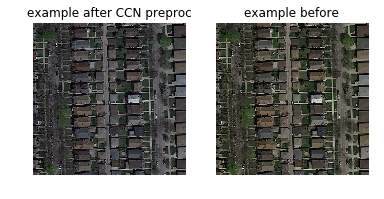

In [3]:
def weight_variable2(shape, nc10):
        initial2 = tf.random_normal(shape, stddev=tf.sqrt(2./tf.to_float(ncl0)) )
        return tf.Variable(initial2)

def conv2d(x,W):
        return tf.nn.conv2d(x,W,strides=[1, 1, 1, 1], padding='SAME')
    
def max_pool_2x2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

def weight_variable(shape):
        initial = tf.truncated_normal(shape, stddev=1/np.sqrt(d/2) )
        return tf.Variable(initial)
    
def bias_variable(shape):
    initial = tf.constant(0.01,shape=shape)
    return tf.Variable(initial)

def preprocess_image_for_cnn(img):
    img = img.copy()
    d = img.shape[2]
    output_img = np.zeros([img.shape[0]*img.shape[1],d])
    for i in range(d):
        img[:,:,i] -= np.mean(img[:,:,i])
        img[:,:,i] /= np.linalg.norm(img[:,:,i])
        output_img[:,i] = img[:,:,i].reshape(img.shape[0]*img.shape[1]);
    
    return output_img

train_data = np.zeros([100,160000,3])
for i in range(n):
    train_data[i,:,:] = preprocess_image_for_cnn(imgs[i])
    

img1 = imgs[0]

train_labels = np.array(gt_imgs)

print('train labels shape= ', train_labels.shape)


plt.rcParams['figure.figsize'] = (6.0, 6.0) # set default size of plots
plt.subplot(121);
img_preprocessed = preprocess_image_for_cnn(img1).reshape([400,400,3])
img_preprocessed -= np.min(img_preprocessed);
img_preprocessed /= np.max(img_preprocessed);
plt.imshow(img_preprocessed);
plt.title('example after CCN preproc');
plt.axis('off')
plt.subplot(122);
plt.imshow(img1); print(np.min(img1))
plt.title('example before');
plt.axis('off');
plt.show()

# Model 1 
In the first model it has been implemented a baseline softmax classifier using a single convolutional layer and a one fully connected layer. For the initial baseline
it has not be used any regularization, dropout, or batch normalization.

The equation of the classifier is simply:


$$
y=\textrm{softmax}(ReLU( x_{400x400,3} \ast W_1+b_1)W_2+b_2) 
$$

For this first attempt have been applied 64 filters with size 10x10.  

In [5]:
# CNN for 3 colors - building computational graph

tf.reset_default_graph()

pix_w = 400      # image width in pix
d = pix_w*pix_w  # data dimensionality
nr_cols = 3      # number of colors 
batch_size = 20      # batch size

#Size and number of filters
K0 = 10   # size of the patch
F0 = 12  # number of filters
ncl0 = K0*K0*F0

# Inputs
xin_3cols = tf.placeholder(tf.float32,[batch_size,d, nr_cols]);  
y_truth = tf.placeholder(tf.float32,[batch_size,d]);

Wcl0 = tf.Variable(tf.truncated_normal([nr_cols,K0,K0,1,F0], stddev=tf.sqrt(2./tf.to_float(ncl0)) )); print('Wcl=',Wcl0.get_shape())
bcl0 = bias_variable([nr_cols,F0]); print('bcl0=',bcl0.get_shape()) #in ReLu case, small positive bias added to prevent killing of gradient when input is negative.

#Reshaping the input to size 400x400
x_2d0_r = tf.reshape(xin_3cols[:,:,0], [-1,pix_w,pix_w,1]); print('x_2d_r=',x_2d0_r.get_shape())
x_2d0_g = tf.reshape(xin_3cols[:,:,1], [-1,pix_w,pix_w,1]); print('x_2d_g=',x_2d0_g.get_shape())
x_2d0_b = tf.reshape(xin_3cols[:,:,2], [-1,pix_w,pix_w,1]); print('x_2d_b=',x_2d0_b.get_shape())
    
# Convolutional layer
x_r = tf.nn.conv2d(x_2d0_r, Wcl0[0], strides=[1, 1, 1, 1], padding='SAME')
x_r += bcl0[0]; print('x_r=',x_r.get_shape())

x_g = tf.nn.conv2d(x_2d0_g, Wcl0[1], strides=[1, 1, 1, 1], padding='SAME')
x_g += bcl0[1]; print('x_g=',x_g.get_shape())

x_b = tf.nn.conv2d(x_2d0_b, Wcl0[2], strides=[1, 1, 1, 1], padding='SAME')
x_b += bcl0[2]; print('x_b=',x_b.get_shape())
    
x = tf.pack([x_r, x_g, x_b])
print('x_final=',x.get_shape())

# ReLU activation
x = tf.nn.relu(x)

# Fully Connected layer
nfc = pix_w*pix_w*F0*nr_cols
x = tf.reshape(x, [batch_size,-1]); print('x3=',x.get_shape())
Wfc = tf.Variable(tf.truncated_normal([nfc,d], stddev=tf.sqrt(2./tf.to_float(nfc)) )); print('Wfc=',Wfc.get_shape())
bfc = tf.Variable(tf.zeros([d])); print('bfc=',bfc.get_shape())
y = tf.matmul(x, Wfc); print('y1=',y.get_shape())
y += bfc; print('y2=',y.get_shape())

# Softmax
y = tf.nn.softmax(y); print('y3(SOFTMAX)=',y.get_shape())
print('y_truth',y_truth.get_shape())

total_loss = np.sum(np.abs(y - y_truth))

# Optimization scheme
train_step = tf.train.AdamOptimizer(0.004).minimize(total_loss)

# Accuracy
accuracy = total_loss/(20*pix_w*pix_w)

Wcl= (3, 10, 10, 1, 12)
bcl0= (3, 12)
x_2d_r= (20, 400, 400, 1)
x_2d_g= (20, 400, 400, 1)
x_2d_b= (20, 400, 400, 1)
x_r= (20, 400, 400, 12)
x_g= (20, 400, 400, 12)
x_b= (20, 400, 400, 12)
x_final= (3, 20, 400, 400, 12)
x3= (20, 5760000)
Wfc= (5760000, 160000)
bfc= (160000,)
y1= (20, 160000)
y2= (20, 160000)
y3(SOFTMAX)= (20, 160000)
y_truth (20, 160000)


In [ ]:
# Run Computational Graph
n = 100
batch_size = 20
indices = collections.deque()
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(init)
for i in range(1001):
    
    # Batch extraction
    if len(indices) < batch_size:
        indices.extend(np.random.permutation(n)) 
    idx = [indices.popleft() for i in range(batch_size)]
    batch_x = train_data[idx,:]
    batch_y = train_labels[idx,:]
    
    print(batch_x.shape,batch_y.shape)
    
    # Run CG for vao to increase the test acriable training
    acc_train,total_loss_o = sess.run([accuracy,total_loss], feed_dict={xin_3cols: batch_x, y_truth: batch_y})
    
    # Run CG for test set
    if not i%1:
        print('\nIteration i=',i,', train accuracy=',acc_train,', loss=',total_loss_o)
        acc_test = sess.run(accuracy, feed_dict={xin: test_data, y_label: test_labels})
        print('test accuracy=',acc_test)

Instructions for updating:
Use `tf.global_variables_initializer` instead.
